In [80]:
import sqlite3
from collections import defaultdict
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pytz

## Load Release Dates

In [81]:
df_versions = pd.read_parquet('df_versions.gzip')

# Hack for untagged versions
df_versions.loc['0.9.1'] = df_versions.loc['0.9']['release_date']
df_versions.loc[''] = df_versions.loc['0.1']['release_date']
df_versions.loc['others'] = df_versions.loc['0.1']['release_date']
df_versions.loc['0'] = df_versions.loc['0.1']['release_date']
df_versions.loc['0+unknown'] = df_versions.loc['0.1']['release_date']

df_versions.sort_values(by='release_date', inplace=True)

def get_base_version(ver):
    base_ver = ver.split('-', maxsplit=1)[0].split('+', maxsplit=1)[0]

    if not base_ver in df_versions.index:
        print(f'Error: unknown base version {base_ver}')
        base_ver = ''

    return base_ver

def version2date(version):
    base_version = get_base_version(str(version))
    return df_versions.loc[base_version]['release_date'].to_pydatetime()

def versions2dates(versions):
    return [version2date(version) for version in versions]

## Load Adoption Data

In [82]:
df_adoption = pd.read_parquet('df_adoption.gzip')

## Plot number of active Stations

In [83]:
series_active = df_adoption.groupby('date').sum('adoption')['adoption']
series_active.tail()

date
2022-10-04    119
2022-11-04    110
2022-12-04    122
2023-01-04    210
2023-02-04    159
Name: adoption, dtype: int64

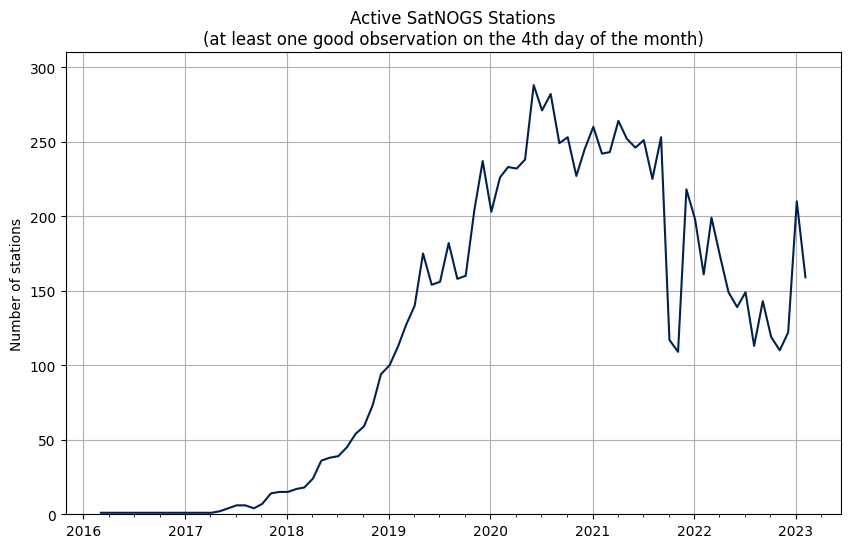

In [106]:
x = series_active.index.values.astype(np.datetime64)
y = series_active.values

fig, ax = plt.subplots(figsize=(10.0, 6.0))

ax.plot(x,y, color=plt.cm.cividis_r(1.0))
# plt.xticks(rotation=45, ha="right")
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
labels = ax.get_xticklabels()
# plt.setp(labels, rotation=45)

if False:
    # tick on each month
    loc_year = mpl.dates.YearLocator()
    loc_month = mpl.dates.MonthLocator(bymonth=[1,4,7,10])
    ax.xaxis.set_major_locator(loc_year, )
    ax.xaxis.set_minor_locator(loc_month)
if False:
    locator = mpl.dates.AutoDateLocator()
    formatter = mpl.dates.ConciseDateFormatter(locator)
    formatter = mpl.dates.ConciseDateFormatter(locator)
if False:
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
ax.xaxis.set_major_locator(mpl.dates.YearLocator(1, month=1, day=1))
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonth=[1,4,7,10]))

    
ax.set_ylabel('Number of stations')
ax.set_title("Active SatNOGS Stations\n(at least one good observation on the 4th day of the month)")
ax.set_ylim([0,310])
ax.grid()
plt.show()

# Check if we have a release date for every base version

In [86]:
missing_base_ver = False

for ver in df_adoption['tag'].unique():
    if ver == '':
        continue
        
    base_ver = get_base_version(ver)
    if base_ver == '':
        print(f'Error: No release date or base version known for tag: \'{ver}\'')
        missing_base_ver = True
        
if not missing_base_ver:
    print('Yes, successfully found a release date for every base version in the data!')

Yes, successfully found a release date for every base version in the data!


# Get a first overview over the version history

In [87]:
df_matrix = df_adoption.set_index(['date','tag'])['adoption'].unstack().fillna(0)
df_matrix

tag,,0+unknown,0+untagged.360.g6672923,0+untagged.362.gdb0bb56,0.3+113.gcb5fb68,0.3+114.g3795bd0,0.3+115.g8c4339a,0.3+115.ga0ea1ad,0.3+115.ga0ea1ad.dirty,0.3+117.g65ce5e3,...,1.8,1.8+7.ga59f810,1.8.1,1.8.1+18.gd10859d,1.8.1+20.g04c56f1,1.8.1+26.gaa33cbb,1.8.1+27.gffccea9,1.8.1+28.g5f23fe0,1.8.1+30.g1dec8ce,1.8.1+34.gf30cc9a
date,,,,,,,,,,,,,,,,,,,,,
2016-03-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-04-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-04,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,19.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0
2022-11-04,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,30.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0
2022-12-04,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,33.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0


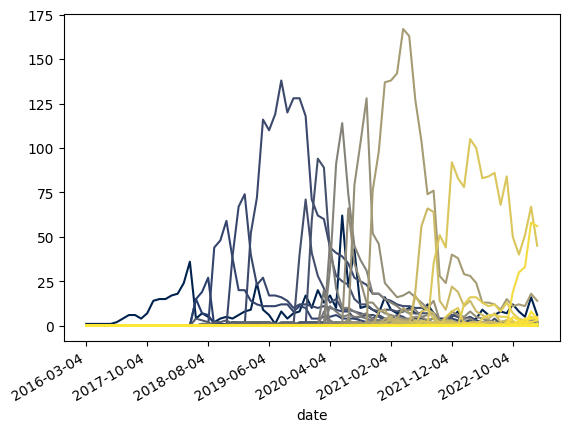

In [88]:
fig, ax = plt.subplots()

cmap = plt.cm.cividis

df_matrix.plot(ax=ax, legend=False, cmap=cmap)
fig.autofmt_xdate()
plt.show()

# Find the "most important" versions

In [89]:
# Note:
# Treshold tweaked so that the cut-off is exactly one entry before the first non-release tag

threshold = 0.85
df_ranking = df_adoption.groupby('tag').max('adoption').sort_values('adoption', ascending=False)
df_top = df_ranking[(df_ranking['adoption'].cumsum() / df_ranking['adoption'].sum()) <= threshold]
df_top

,adoption
tag,
1.4,167
0.9,138
1.3.4,128
1.3.1,114
1.6,105
1.0,94
0.8,74
0.9.1,71
1.3.2,66


# Sort "most important" versions by release date

In [90]:
versions = df_top.join(other=df_versions).sort_values('release_date').index.values.astype('<U8').tolist()
versions[0] = 'others'
versions

['others',
 '0.6.1',
 '0.6.2',
 '0.7',
 '0.8',
 '0.9',
 '0.9.1',
 '1.0',
 '1.1',
 '1.1.2',
 '1.2',
 '1.3.1',
 '1.3.2',
 '1.3.4',
 '1.4',
 '1.5',
 '1.5.1',
 '1.6',
 '1.7',
 '1.8.1']

In [91]:
if 'df_adoption2' in locals():
    del df_adoption2

df_adoption2 = df_adoption.copy()
df_adoption2['simple_version'] = df_adoption['tag'].apply(lambda x: versions[versions.index(x)] if x in versions else '')
df_matrix2 = df_adoption2.groupby(['date', 'simple_version']).sum('adoption').unstack().fillna(0)
df_matrix2 = df_matrix2[df_matrix2.columns[::-1]]
df_matrix2['adoption']

simple_version,1.8.1,1.7,1.6,1.5.1,1.5,1.4,1.3.4,1.3.2,1.3.1,1.2,1.1.2,1.1,1.0,0.9.1,0.9,0.8,0.7,0.6.2,0.6.1,
date,,,,,,,,,,,,,,,,,,,,
2016-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-06-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-04,19.0,7.0,50.0,2.0,1.0,11.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0
2022-11-04,30.0,4.0,40.0,1.0,0.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,20.0
2022-12-04,33.0,3.0,51.0,1.0,0.0,11.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,17.0


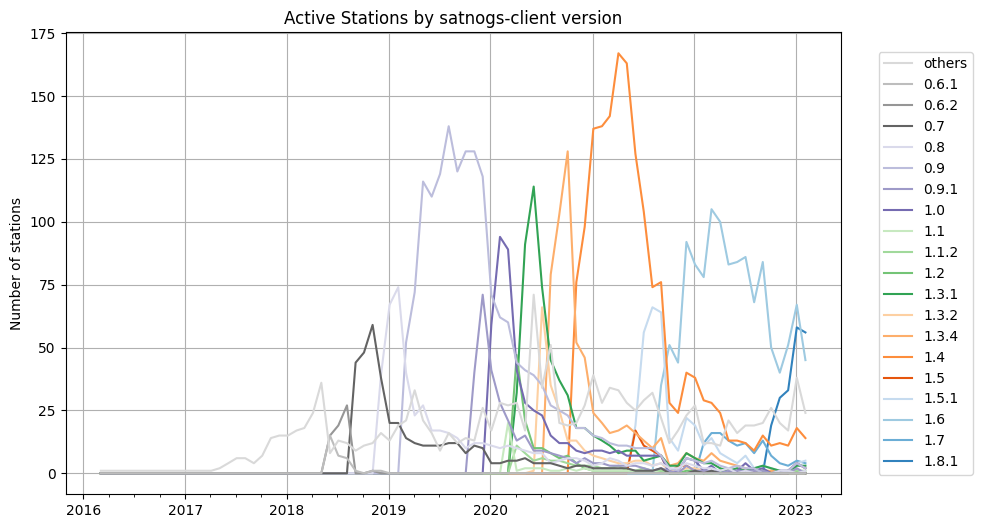

In [105]:
fig, ax = plt.subplots(figsize=(10.0, 6.0))


n = df_short.index.shape[0]
ax.set_prop_cycle('color',[plt.cm.tab20c(i) for i in np.linspace(0.02, 1.0, n)])

x = [datetime.fromisoformat(d) for d in df_matrix2['adoption'].index]
y = df_matrix2['adoption']
labels = df_percent.index.to_list()[:-1] + ['others']

lines = ax.plot(x, y)
aa = lines[0]
for label, line in zip(labels, lines):
    line.set_label(label)

ax.xaxis.set_major_locator(mpl.dates.YearLocator(1, month=1, day=1))
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonth=[1,4,7,10]))

ax.grid()

handles, labelsX = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.04, 0.5), loc="center left")

plt.ylabel('Number of stations')
plt.title('Active Stations by satnogs-client version')

plt.show()

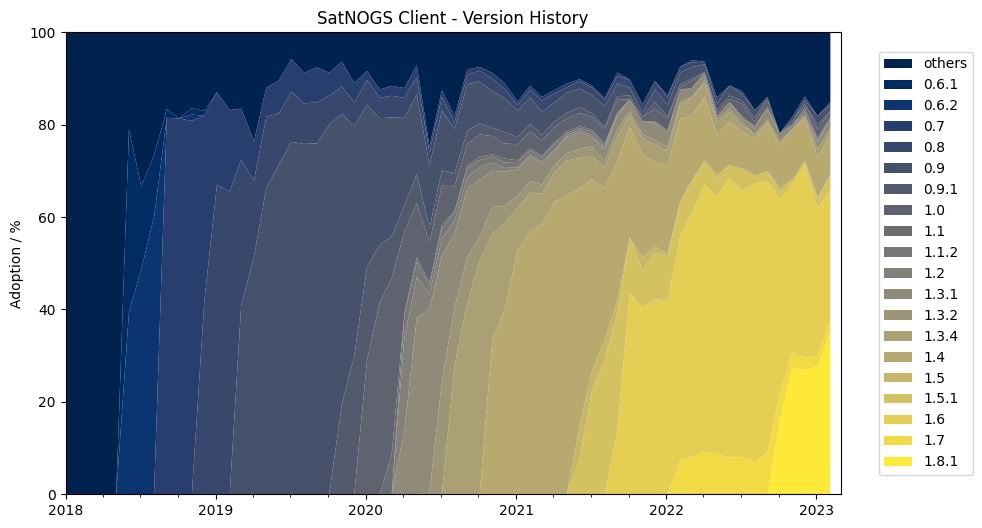

In [17]:
df_short = df_matrix2['adoption'].transpose()
df_percent = (df_short / df_short.sum() * 1e2)

x = [datetime.fromisoformat(d) for d in  df_percent.columns]
y = df_percent.fillna(0).values
labels = df_percent.index.to_list()[:-1] + ['others']
colors = plt.cm.cividis.resampled(df_short.index.shape[0]).colors
colors = reversed(colors)

fig = plt.figure(figsize=(10.0,6.0))
# fig = plt.figure()
ax = fig.subplots()

ax.stackplot(x, y, labels=labels, colors=colors)

handles, labels = ax.get_legend_handles_labels()

label_position = ['side']

if 'box' in label_position:
    ax.legend(handles[::-1], labels[::-1], title='Version', loc='upper left')

if 'side' in label_position:
    handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
    
    plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.04, 0.5), loc="center left")

if 'distributed' in label_position:
    ls = [[0.85, 0.04, labels[0]],
          [0.65, 0.04, labels[2]],
          [0.45, 0.04, labels[3]],
          [0.32, 0.04, labels[4]],
          [0.16, 0.04, labels[5]],
          [0.012, 0.04, labels[6]],
          [0.012, 0.84, labels[7]],
          [0.012, 0.95, labels[9]],
         ]
    for l in ls:
        ax.text(l[0],l[1],l[2],
                transform=ax.transAxes,
                bbox={'facecolor': 'white', 'alpha': 0.6, 'pad': 5}
           )

# plt.xticks(rotation=45, ha="right")
# fig.autofmt_xdate()
ax.xaxis.set_major_locator(mpl.dates.YearLocator(1, month=1, day=1))
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonth=[1,4,7,10]))

# ax.xaxis.set_ticks([3,20])
ax.set_xlim((datetime(2018,1,1), datetime(2023,3,1)))

ax.set_ylim((0,100))

plt.ylabel('Adoption / %')
plt.title('SatNOGS Client - Version History')
plt.show()